# Time Series Forecast: Daily Minimum Temperatures in Melbourne

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

In [4]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        index = 0
        for row in reader:
            times.append(index)
            temperatures.append(float(row[1]))
            index += 1
            
    return times, temperatures

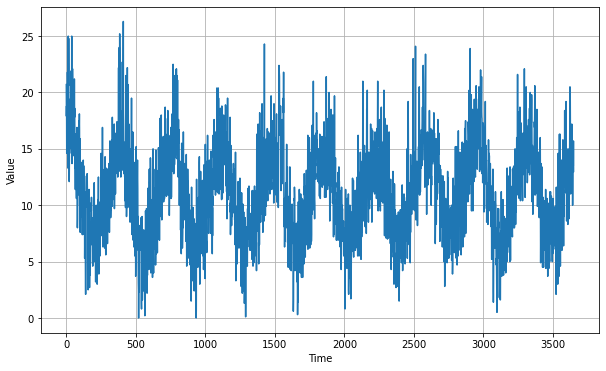

In [5]:
# Test function and save all "global" variables within the G class
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [20]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                               strides=1, padding='causal',
                               activation='relu',
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Dense(1)
    ])

    return model

## Compiling the model

In [23]:
def create_model():
    
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])

    return model

In [24]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 [==============================] - 5s 189ms/step - loss: 9.3581 - mae: 9.8561
Epoch 2/50
10/10 [==============================] - 2s 188ms/step - loss: 7.5758 - mae: 8.0721
Epoch 3/50
10/10 [==============================] - 2s 179ms/step - loss: 5.5583 - mae: 6.0463
Epoch 4/50
10/10 [==============================] - 2s 185ms/step - loss: 3.6457 - mae: 4.1219
Epoch 5/50
10/10 [==============================] - 2s 186ms/step - loss: 2.7428 - mae: 3.2084
Epoch 6/50
10/10 [==============================] - 2s 179ms/step - loss: 2.7235 - mae: 3.1910
Epoch 7/50
10/10 [==============================] - 2s 178ms/step - loss: 2.6513 - mae: 3.1197
Epoch 8/50
10/10 [==============================] - 2s 181ms/step - loss: 2.6090 - mae: 3.0729
Epoch 9/50
10/10 [==============================] - 2s 188ms/step - loss: 2.5620 - mae: 3.0258
Epoch 10/50
10/10 [==============================] - 2s 178ms/step - loss: 2.4619 - mae: 2.9249
Epoch 11/50
10/10 [==============================

## Evaluating the forecast

In [25]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Model forecasts

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

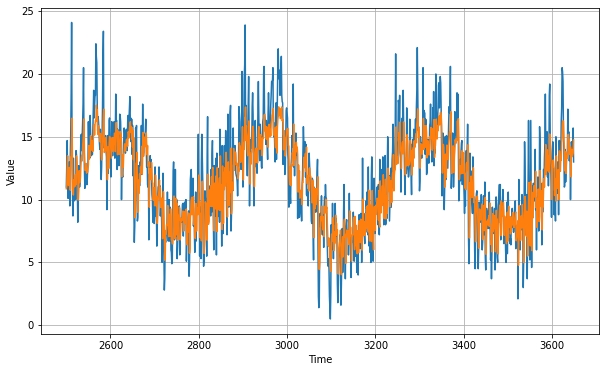

In [27]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.35, mae: 1.79 for forecast
